In [1]:
import os
import numpy as np
import pandas as pd
import array
import mmap
import matplotlib.pyplot as plt
import seaborn as sns
sep = '/'

In [2]:
path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/2018-05-03_02.dat"
kilosort_folder = '/Users/sharplab/tran/cat/Tran'
recording = '2018-05-03_02 (done)'
fig_path = "/Users/sharplab/tran/cat/Tran/2018-05-03_02 (done)/figures"
data = np.memmap(path, shape =(327354368,32), dtype = np.int16)


def load_kilosort_arrays(recording):
    spike_clusters = np.load('spike_clusters.npy')
    spike_times = np.load('spike_times.npy')
    cluster_groups = pd.read_csv('cluster_groups.csv', sep='\t')
    try:  # check data quality
        assert np.shape(spike_times.flatten()) == np.shape(spike_clusters)
    except AssertionError:
        AssertionError('Array lengths do not match in recording {}'.format(
            recording))
    return spike_clusters, spike_times, cluster_groups

def load_data(recording, kilosort_folder, verbose, sep):
    if verbose:
        print('\nLoading Data:\t{}\n'.format(recording))
        os.chdir(sep.join([kilosort_folder, recording]))
        spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(
            recording)
    return spike_clusters, spike_times, cluster_groups

def get_good_cluster_numbers(cluster_groups_df):
    good_clusters_df = cluster_groups_df.loc[cluster_groups_df['group'] == 'good', :]
    return good_clusters_df['cluster_id'].values

spike_clusters, spike_times, cluster_groups = load_data(recording=recording,
                                                        kilosort_folder=kilosort_folder,
                                                        verbose=True,
                                                        sep=sep)

good_cluster_numbers = get_good_cluster_numbers(cluster_groups)


Loading Data:	2018-05-03_02 (done)



In [83]:
def find_baseline(max_peak_time, from_start_to_max, correct_chan): 
    baseline = []
    ''' 
    Baseline is defined as the first point where there's a significant y-value increase. 
    
    aka. the difference in y values between x+1 and x is twice that of x and x-1. x is the data point
    '''
    
    for time_point in from_start_to_max:
        if np.absolute(correct_chan.loc[time_point+1][0]-correct_chan.loc[time_point][0])> 20 and correct_chan.loc[time_point]['trend']=='increase': 
            return time_point


def find_return_point(min_peak_time, from_min_to_end, correct_chan):
    return_point = []
    baseline_value = correct_chan.loc[find_baseline(max_peak_time, from_start_to_max, correct_chan)][0]
    
    '''
    return point is the first value just before the value becoming higher than baseline value
    '''
    for return_time_point in from_min_to_end:
        if correct_chan.loc[return_time_point+1][0] > baseline_value or correct_chan.loc[return_time_point+1]['trend']=='decrease':
            return return_time_point
        else:
            pass

def plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, baseline_value, return_point):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*return_point, np.linspace(-400, 650, 5), 'k')
    
    
    '''
    Find the estimation of the return to baseline value if the return point is not very accurate due to not having enough data points
    
    y=ax+b
    
    where y is our y value x is time
    
    we can find the values of a and b by solving the simultaneous equation using the x and y values of the two data points above and below:

    y1 = ax1 + b 
    y2 = ax2 + b 

    => a = (x1-x2)/(y1-y2)
   
       b = y1-ax1
           a = (correct_chan.loc[return_point][0]-correct_chan.loc[return_point+1][0])/(return_point-(return_point+1))
    b = correct_chan.loc[return_point][0]-a*(return_point)

    estimated_return_time = (baseline_value-b)/a
    plt.plot(np.ones(5)*estimated_return_time, np.linspace(-400, 650, 5), 'r')
    '''
    
    


    plt.savefig(sep.join(fig_to_save))
    plt.close()
    

def find_return_point_when_no_min(max_peak_time, counter_when_no_min, correct_chan):
    return_point_when_no_min = []
    base_value = correct_chan.loc[find_baseline(max_peak_time, from_start_to_max, correct_chan)][0]
    
    '''
    The time point just before the y-value becoming lower than baseline value (from the max peak)
    '''
  
    for no_min_return_point in counter_when_no_min:
        if correct_chan.loc[no_min_return_point+1][0] < baseline_value:
            return no_min_return_point
        else:
            pass

def plot_waveform_when_no_min(fig_to_save, baseline, correct_chan, baseline_value, no_min_return_point):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*no_min_return_point, np.linspace(-400, 650, 5), 'k')

    plt.savefig(sep.join(fig_to_save))
    plt.close()
    
def find_baseline_for_down_up(min_peak_time, from_start_to_min, correct_chan): #Method to find baseline is standardised for all types of waveforms 
    baseline_for_down_up = []
    
    ''' 
    Same as standard baseline except the value is the first point where there's a significant y-value DECREASE
    '''
    
    for time_point_for_down_up in from_start_to_min:
        if np.absolute(correct_chan.loc[time_point_for_down_up+1][0]-correct_chan.loc[time_point_for_down_up][0])> 20 and correct_chan.loc[time_point_for_down_up]['trend']=='decrease': 
            return time_point_for_down_up

def find_return_point_for_down_up(min_peak_time, from_min_to_end, correct_chan):
    baseline_value = correct_chan.loc[find_baseline_for_down_up(min_peak_time, from_start_to_min, correct_chan)][0]
    
    '''
    The time point just before the y-value becoming higher than baseline value (from the min peak)
    '''
    for return_point_for_down_up in from_min_to_end:
        if correct_chan.loc[return_point_for_down_up+1][0] > baseline_value or correct_chan.loc[return_point_for_down_up+1]['trend']=='decrease':
            return return_point_for_down_up
        else:
            pass
        
def plot_waveform_for_down_up(fig_to_save, baseline_for_down_up, correct_chan, baseline_value_for_down_up, return_point_for_down_up):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*baseline_for_down_up, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*return_point_for_down_up, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
 
    plt.savefig(sep.join(fig_to_save))
    plt.close()
    
def find_special_baseline(small_peak_time, counter_for_special, correct_chan): #Method to find baseline is standardised for all types of waveforms 
    special_baseline = []

    ''' 
    The value is the first point where there's a significant y-value INCREASE before the small max peak
    '''
    for special_time_point in counter_for_special:
        if np.absolute(correct_chan.loc[special_time_point+1][0]-correct_chan.loc[special_time_point][0])> 20 and correct_chan.loc[special_time_point]['trend']=='increase': 
            return special_time_point

def find_special_return_point(small_peak_time, from_min_to_end, correct_chan):
    special_baseline_value = correct_chan.loc[find_baseline_for_down_up(small_peak_time, from_start_to_min, correct_chan)][0]
    
    '''
    return point is the first value from the min peak, just before the value higher than baseline value
    '''
    for special_return_point in from_min_to_end:
        if correct_chan.loc[special_return_point+1][0] > special_baseline_value or correct_chan.loc[special_return_point+1]['trend']=='decrease':
            return special_return_point
        else:
            pass
        
def plot_special_waveform(fig_to_save, special_baseline, correct_chan, special_baseline_value, special_return_point):
    plt.plot(correct_chan['y_values'], linestyle=None, marker='.')
    plt.plot(np.ones(5)*special_baseline, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*special_return_point, np.linspace(-400, 650, 5), 'k')
    plt.plot(np.ones(5)*min_peak_time, np.linspace(-400, 650, 5), 'k')
    plt.savefig(sep.join(fig_to_save))
    plt.close()



In [84]:
num_spikes_for_averaging = 1000
num_channels = 32
num_samples_per_waveform = 60
waveform_window = np.arange(int(-num_samples_per_waveform/2),int(num_samples_per_waveform/2))

for cluster_no in np.arange(0,40,1):
    cluster_to_plot = good_cluster_numbers[cluster_no]
    fig_to_save = [fig_path,"cluster"+ str(cluster_to_plot)+'png']
    df = pd.DataFrame({'cluster':spike_clusters.flatten(), 'spike_times':spike_times.flatten()})
    df = df.loc[df['cluster'].isin(good_cluster_numbers)]
    extracted_spikes = df[df['cluster']==cluster_to_plot]['spike_times'][0:num_spikes_for_averaging]
    threeD_matrix = np.zeros((num_spikes_for_averaging, num_samples_per_waveform, num_channels)) # Create the 3D matrix witht he shape (1000,60,32)

    for spike in np.arange(0,num_spikes_for_averaging):
        start_index = int(extracted_spikes.iloc[spike]+waveform_window[0])  #  start of waveform in raw data
        end_index = int((extracted_spikes.iloc[spike]+waveform_window[-1])+1)  #  end of waveform in raw data

        waveform = data[start_index:end_index, 0:num_channels] #  extract waveform from raw data
        threeD_matrix[spike, :, :] = waveform[:,:]  #  add extracted waveform to 3d matrix

    mean_waveform = np.mean(threeD_matrix, axis=0)
    waveform_per_channel_df = pd.DataFrame(mean_waveform)
    maxes = waveform_per_channel_df.apply(np.min, axis=0)
    lab = maxes.idxmin()
    correct_chan = waveform_per_channel_df.loc[:, lab]
    correct_chan = correct_chan.reset_index()
    correct_chan.columns = ['figure', 'y_values']
    correct_chan.set_index('figure', inplace=True)
    new_list = [correct_chan['y_values'][trend_values] for trend_values in np.arange(0,59,1) if (correct_chan['y_values'][trend_values]<correct_chan['y_values'][trend_values+1])]
    correct_chan['trend'] = np.where(correct_chan['y_values'].isin(new_list), 'increase', 'decrease')
    min_value = correct_chan['y_values'].min()
    max_value = correct_chan['y_values'].max()
    min_peak_time = correct_chan['y_values'].idxmin()
    max_peak_time = correct_chan['y_values'].idxmax()

    small_peak_value = correct_chan[:min_peak_time].max()[0]
    small_peak_time = correct_chan[:min_peak_time]['y_values'].idxmax()

    ''' 
    Split the data into 3 periods for analysis
    1) from start to the max (baseline value is in this period)
    2) from max to min (can just index max and min peak time directly)
    3) from min to end (return of baseline value is in this period)

    In case that there's no min peak, the data is split into
    1) from start to max
    2) from max to end
    '''

    from_start_to_max = np.arange(1, max_peak_time+1, 1)
    from_start_to_min = np.arange(1, min_peak_time+1, 1)
    from_min_to_end = np.arange(min_peak_time, 59, 1) 
    counter_when_no_min = np.arange(max_peak_time, 59, 1)
    counter_for_special = np.arange(1, small_peak_time, 1)
    
    #Category 1:
    if (max_value<60) or (correct_chan[:min_peak_time].max()[0]<60 and correct_chan[min_peak_time:].max()[0]>60):
        baseline_for_down_up = find_baseline_for_down_up(min_peak_time, from_start_to_min, correct_chan)
        baseline_value_for_down_up= correct_chan.loc[baseline_for_down_up][0]
        return_point_for_down_up = find_return_point_for_down_up(min_peak_time, from_min_to_end, correct_chan)
        data_table = pd.DataFrame({'Base to min (ms)':(min_peak_time-baseline_for_down_up)/30,
                                   'Base to max (ms)': np.nan,
                                   'Return to base (ms)': (return_point_for_down_up-baseline_for_down_up)/30, 
                                   'Amplitude base-min (V)': min_value - baseline_value_for_down_up,
                                   'Amplitude base-max (V)': np.nan,
                                   'Amplitude min-max (V)': np.nan,
                                  'spike_category': 'down_up'},
                                  index=[0])

        plot_waveform_for_down_up(fig_to_save, baseline_for_down_up, correct_chan, baseline_value_for_down_up, return_point_for_down_up)


    #Category 2:
    elif (max_value)>60 and (min_value>-100):

        baseline = find_baseline(max_peak_time, from_start_to_max, correct_chan)
        baseline_value = correct_chan.loc[baseline][0]
        no_min_return_point = find_return_point_when_no_min(max_peak_time, counter_when_no_min, correct_chan)
        data_table = pd.DataFrame({'Base to min (ms)': np.nan,
                                   'Base to max (ms)':(max_peak_time-baseline)/30, 
                                   'Return to base (ms)': (no_min_return_point-baseline)/30, 
                                   'Amplitude base-min (V)': np.nan,
                                   'Amplitude base-max (V)':max_value - baseline_value, 
                                   'Amplitude min-max (V)': np.nan,
                                  'spike_category': 'just_up'}, index=[0])

        plot_waveform_when_no_min(fig_to_save, baseline, correct_chan, baseline_value, no_min_return_point)

    #Category 3:    
    elif (correct_chan[:min_peak_time].max()[0])>60 and (correct_chan[min_peak_time:].max()[0]>60) and (correct_chan[:min_peak_time].max()[0]<correct_chan[min_peak_time:].max()[0]):
        special_baseline = find_special_baseline(small_peak_time, counter_for_special, correct_chan)
        special_baseline_value = correct_chan.loc[special_baseline][0]
        special_return_point = find_special_return_point(small_peak_time, from_min_to_end, correct_chan)
        data_table = pd.DataFrame({'Base to min (ms)':(min_peak_time-special_baseline)/30, 
                                   'Base to max (ms)': np.nan,
                                   'Return to base (ms)': (special_return_point-special_baseline)/30, 
                                   'Amplitude base-min (V)': min_value - special_baseline_value,
                                   'Amplitude base-max (V)': small_peak_value - special_baseline_value,
                                   'Amplitude min-max (V)':small_peak_value + np.absolute(min_value),
                                  'spike_category': 'up_down_up'},
                                  index=[0])
        plot_special_waveform(fig_to_save, special_baseline, correct_chan, special_baseline_value, special_return_point)

    #Category 4:  
    else:

        baseline = find_baseline(max_peak_time, from_start_to_max, correct_chan)
        baseline_value = correct_chan.loc[baseline][0]
        return_point = find_return_point(min_peak_time, from_min_to_end, correct_chan)
        data_table = pd.DataFrame({'Base to max (ms)':(max_peak_time-baseline)/30, 
                                   'Base to min (ms)':(min_peak_time-baseline)/30, 
                                   'Return to base (ms)':(return_point-baseline)/30, 
                                   'Amplitude base-max (V)':max_value - baseline_value, 
                                   'Amplitude min-max (V)':max_value + np.absolute(min_value),
                                  'spike_category': 'up_down_up'}, index=[0])

        plot_waveform(fig_to_save, correct_chan, baseline, min_peak_time, baseline_value, return_point)


In [78]:
cluster_to_plot

126

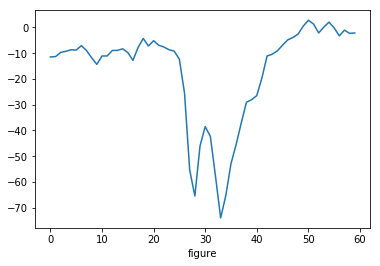

In [79]:
correct_chan['y_values'].plot()

In [80]:
correct_chan['y_values']

figure
0    -11.462
1    -11.311
2     -9.686
3     -9.286
4     -8.663
5     -8.797
6     -7.056
7     -8.984
8    -11.811
9    -14.340
10   -11.086
11   -11.077
12    -8.954
13    -8.912
14    -8.300
15    -9.737
16   -12.785
17    -7.738
18    -4.282
19    -7.225
20    -5.148
21    -6.917
22    -7.599
23    -8.662
24    -9.212
25   -12.376
26   -25.582
27   -55.372
28   -65.462
29   -46.028
30   -38.508
31   -42.279
32   -57.797
33   -73.956
34   -65.264
35   -52.920
36   -45.481
37   -37.036
38   -29.049
39   -28.062
40   -26.476
41   -19.612
42   -11.094
43   -10.406
44    -9.089
45    -6.878
46    -4.845
47    -3.907
48    -2.611
49     0.470
50     2.791
51     1.324
52    -2.134
53     0.143
54     2.063
55    -0.199
56    -3.278
57    -1.047
58    -2.319
59    -2.140
Name: y_values, dtype: float64

In [75]:
np.absolute(correct_chan.loc[15][0]-correct_chan.loc[14][0])

33.635999999999996